In [66]:
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model, fit_gpytorch_mll
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from typing import List

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [67]:
class CategoricalHartmann():
    """Class for creating a synthetic Hartmann function with a categorical variable."""
    def __init__(self, levels : int = 3, dims : int = 3, noise_std : float = None, seed : int = 42):
        self.levels = levels
        assert dims in (3, 6), "dims must be either 3 or 6"
        self.dims = dims
        
        np.random.seed(seed) # good seeds: 42, 120, 1

        self.level_intercepts = torch.tensor(np.random.permutation(np.arange(0,levels/1.5, 0.5))[:levels])
        # self.level_intercepts = torch.tensor(random.sample(range(levels+1), levels))
        self.level_slopes = torch.tensor(np.random.permutation(np.linspace(1,2.5,20))[:levels])
        self.obj = Hartmann(dim=dims, noise_std=noise_std, bounds=[(0,1)]*dims, negate=True)

        self.optimal_params = self.get_max()

    def get_max(self):
        self.optima = torch.zeros(self.levels)
        if self.dims == 3:
            for i in range(self.levels):
                self.optima[i] = self.obj(torch.tensor([0.114614, 0.555649, 0.852547]))*self.level_slopes[i] + self.level_intercepts[i]
        else:
            for i in range(self.levels):
                self.optima[i] = self.obj(torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]))*self.level_slopes[i] + self.level_intercepts[i]
        
        return torch.argmax(self.optima).item()

    def __call__(self, cat : int, X : List[float]):
        # assert cat < self.levels, f"Invalid Category {cat}"
        return self.obj(X)*self.level_slopes[cat] + self.level_intercepts[cat]
    
    def __repr__(self):
            # Define the string representation of the object
            return f"CategoricalHartmann\n    Categories = {self.levels}\n    Continuous Dims = {self.dims}\n    LevelIntercepts = {self.level_intercepts.tolist()}\n    LevelSlopes = {self.level_slopes.tolist()}\n    Optimum: CAT {self.optimal_params} | {torch.max(self.optima)}"

In [68]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sampler(n=2, levels=3, dims=3):
    """Randomly sample the design space."""
    cont = torch.rand(n, dims, dtype=torch.float64)
    cat = torch.randint(0, levels, (n, 1), dtype=torch.float64)
    # cat = torch.tensor(np.arange(0, 11, 1))[:,None]
    sample = torch.concat([cat, cont], dim=-1)
    return sample

seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [69]:
seeds = np.loadtxt('seeds.txt', delimiter=',', dtype=int)
n_init = 5
n_campaigns = 5
budget = 30-n_init

levels = 5 # number of categories
dims = 6 # number of continuous dimensions
CatHart = CategoricalHartmann(levels=levels, dims=dims, noise_std=0.0, seed=10)
print(CatHart)
X_ = random_sampler(n=n_init, levels=levels, dims=dims) # deliberately seeking bad samples
y_ = CatHart(cat=X_[:,0].to(int), X=X_[:,1:])[:,None]

CategoricalHartmann
    Categories = 5
    Continuous Dims = 6
    LevelIntercepts = [1.0, 3.0, 0.0, 1.5, 2.0]
    LevelSlopes = [1.3947368421052633, 1.0789473684210527, 2.026315789473684, 1.1578947368421053, 1.9473684210526314]
    Optimum: CAT 4 | 8.469874534162251


In [70]:
ensemble_y = np.zeros((n_campaigns, n_init+budget))
ensemble_X = np.zeros((n_campaigns, 7, n_init+budget))
# ensemble_params = np.zeros((n_campaigns, 8, budget))
ensemble_acqf = np.zeros((n_campaigns, budget))

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(seeds[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()

    # iterate through each trial up to budget - n_initial
    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = MixedSingleTaskGP(
            train_X=X,
            train_Y=y,
            cat_dims=[0],
            input_transform = Normalize(d=X.shape[-1], indices=list(np.arange(0, dims, 1)+1)),
            outcome_transform = Standardize(m=y.shape[-1]),
        )

        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        bounds = torch.stack([torch.zeros(dims+1), torch.ones(dims+1)])
        bounds[0,0] = 0.0
        bounds[1,0] = float(levels-1)

        X_new, acq_value = optimize_acqf_mixed(
            acq_function = UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            fixed_features_list=[{0:i} for i in range(levels)],
            q=1,
            num_restarts=20,
            raw_samples=250,
        )

        ensemble_acqf[i,j] = acq_value.item()

        X = torch.cat([X, X_new])
        y = torch.cat([y, CatHart(cat=X_new[:,0].to(int), X=X_new[:,1:])[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")

    ensemble_y[i,:] = y.flatten()
    ensemble_X[i,:,:] = X.T

  0%|          | 0/5 [00:00<?, ?it/s]/Users/andrewf/miniconda3/envs/take_your_time/lib/python3.9/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
Campaign 1 | Best Value 5.367: 100%|██████████| 25/25 [00:40<00:00,  1.63s/it]/s]
Processing Trial 25 of Campaign 1:  20%|██        | 1/5 [00:40<02:42, 40.67s/it]/Users/andrewf/miniconda3/envs/take_your_time/lib/python3.9/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
Campaign 2 | Best Value 4.559: 100%|██████████| 25/25 [00:31<00:00,  1.28s/it] 40.67s/it]
Processing Trial 25 of Campaign 2:  40%|████      | 2/5 [01:12<01:46, 35.55s/it]/Users/andrewf/miniconda3/envs/take_your_time/lib/python3.9/site-packages/botorch/optim/initializers.py:432: BadIniti

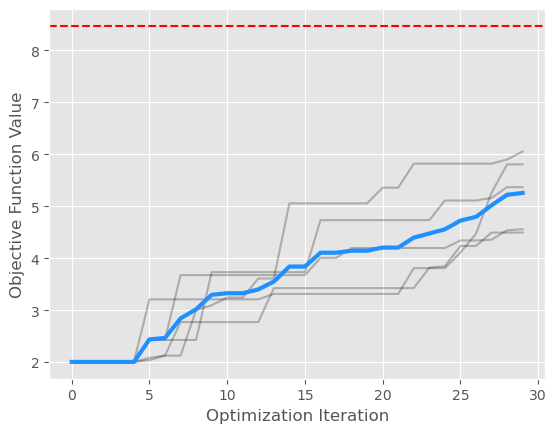

In [72]:
best_to_trial = np.maximum.accumulate(ensemble_y, axis=1)
best_to_trial_mean = np.mean(best_to_trial, axis=0)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.plot(best_to_trial_mean, lw=3, color='dodgerblue', label='mean')
plt.axhline(torch.max(CatHart.optima).item(), color='red', ls='--', label='optimal')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.show()